# Data Loading

#Andrea Fassbender
#10/17/2019

In [87]:
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

## Demonstrate how to use `intake-esm`
[Intake-esm](https://intake-esm.readthedocs.io) is a data cataloging utility that facilitates access to CMIP data. It's pretty awesome.

An `intake-esm` collection object establishes a link to a database that contains file locations and associated metadata (i.e. which experiement, model, etc. thet come from). 

### Opening a collection
First step is to open a collection by pointing to the collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). 

The collection JSON files are stored locally in this repository for purposes of reproducibility---and because Cheyenne compute nodes don't have Internet access. 

The primary source for these files is the [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) repository. Any changes made to these files should be pulled from that repo. For instance, the Pangeo cloud collection is available [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).

In [88]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 698724 entries:
	> 13 activity_id(s)

	> 24 institution_id(s)

	> 47 source_id(s)

	> 68 experiment_id(s)

	> 162 member_id(s)

	> 35 table_id(s)

	> 1027 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 248 version(s)

	> 6813 time_range(s)

	> 698724 path(s)

`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

In [89]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,day,pr,gn,NaN,v20190702,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,hfls,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,prsn,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,va,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,tas,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...


It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [90]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'dcpp_init_year',
       'version', 'time_range', 'path'],
      dtype='object')

In [91]:
col.df.variable_id

0             pr
1           hfls
2           prsn
3             va
4            tas
           ...  
698719        pp
698720       no3
698721    dissic
698722        o2
698723     remoc
Name: variable_id, Length: 698724, dtype: object

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [92]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 68,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', 'amip-future4K',
                              'amip-m4K', 'a4SST', 'aqua-p4K', 'piSST',
                              'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-assim',
                   

#### Searching for specific datasets

Let's find all the column integrated npp data at monthly frequency. A quick check of the avaialble data indicates that only historical data are available at present for this variable. https://docs.google.com/spreadsheets/d/1jn_FzGLw7GluO4sH_NHPIJ0R757b-LP-zV0ThSKvXDM/edit#gid=790478368 

Use only 1st member of ensemble: r1i1p1f1

In [93]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon', variable_id='intpp', member_id='r1i1p1f1', grid_label='gn')
#cat.df

In [94]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Omon', 
                 variable_id='intpp', grid_label='gn', member_id='r1i1p1f1')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)
models

['IPSL-CM6A-LR']

In [95]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon', 
                 variable_id='intpp', grid_label='gn', member_id='r1i1p1f1', source_id=models)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
537553,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,intpp,gn,NaN,v20180803,185001-201412,/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-C...
698408,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190119,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/IPSL...


Now perform the same steps to get the gridcell area. [areacello] Grid-Cell Area for Ocean Variables

In [96]:
#list models with ocean grid cell area
cat2 = col.search(experiment_id=['historical', 'ssp585'], table_id='Ofx', variable_id='areacello', member_id='r1i1p1f1', grid_label='gn')

#see if this variable exists for our model of interest (IPSL...)
cat2 = col.search(experiment_id=['historical', 'ssp585'], table_id='Ofx', 
                 variable_id='areacello', grid_label='gn', member_id='r1i1p1f1', source_id='IPSL-CM6A-LR')
cat2.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
537397,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Ofx,areacello,gn,NaN,v20180803,NaN,/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-C...
698398,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,Ofx,areacello,gn,NaN,v20190119,NaN,/glade/collections/cmip/CMIP6/ScenarioMIP/IPSL...


### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [97]:
#intpp data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

#ocean grid cell area data
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [98]:
#intpp keys
dset_dict.keys()

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn', 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Omon.gn'])

In [99]:
#ocean grid cell area keys
dset_dict2.keys()

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.historical.Ofx.gn', 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Ofx.gn'])

We can access these datasets as follows.

In [100]:
ds_hist = dset_dict['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn']
ds_85 = dset_dict['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Omon.gn']
ds_hist_oa = dset_dict2['CMIP.IPSL.IPSL-CM6A-LR.historical.Ofx.gn']
ds_85_oa = dset_dict2['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Ofx.gn']
ds_85.intpp

<xarray.DataArray 'intpp' (member_id: 1, time: 1032, y: 332, x: 362)>
dask.array<transpose, shape=(1, 1032, 332, 362), dtype=float32, chunksize=(1, 1032, 332, 362), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) float64 15.5 45.0 74.5 ... 3.133e+04 3.136e+04 3.14e+04
Dimensions without coordinates: y, x
Attributes:
    long_name:           Primary Organic Carbon Production by All Types of Ph...
    units:               mol m-2 s-1
    online_operation:    average
    cell_methods:        area: mean where sea depth: sum where sea time: mean
    interval_operation:  2700 s
    interval_write:      1 month
    cell_measures:       area: areacello
    standard_name:       net_primary_mole_productivity_of_biomass_expressed_a...
    description:         Vertically integrated total primary (organic carbon)...
    history:             none

# Plot integrated npp at one location over time

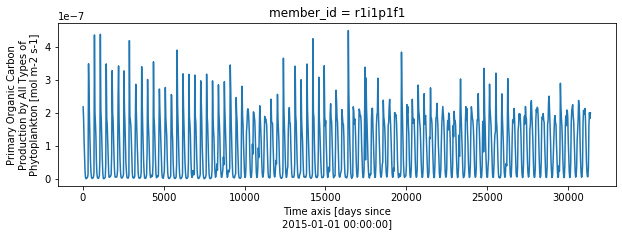

In [71]:
ds_85_sub = ds_85.isel(x=330, y=90) 

fig = plt.figure(figsize=(10,3))

ds_85_sub.intpp.plot()

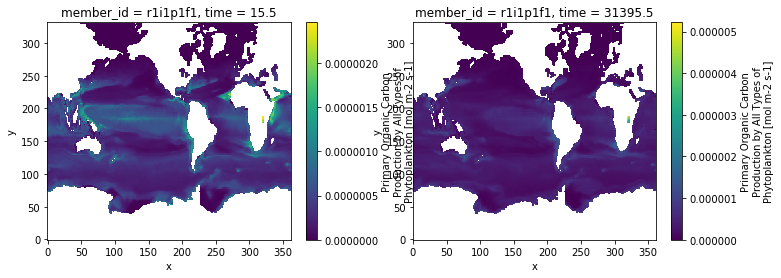

In [72]:
# Make a map of intpp at the start and end of the time series

fig = plt.figure(figsize=(12, 4))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 2, 1)
ds_85.intpp.isel(time=0).plot()

ax2 = fig.add_subplot(1, 2, 2)
ds_85.intpp.isel(time=1031).plot()

In [75]:
ds_85_oa.areacello

<xarray.DataArray 'areacello' (member_id: 1, y: 332, x: 362)>
dask.array<transpose, shape=(1, 332, 362), dtype=float32, chunksize=(1, 332, 362), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: y, x
Attributes:
    standard_name:     cell_area
    long_name:         Grid-Cell Area
    units:             m2
    online_operation:  once
    cell_methods:      area: sum
    cell_measures:     area: area
    description:       Cell areas for any grid used to report ocean variables...
    history:           none

Text(0.5, 0, 'Latitude')

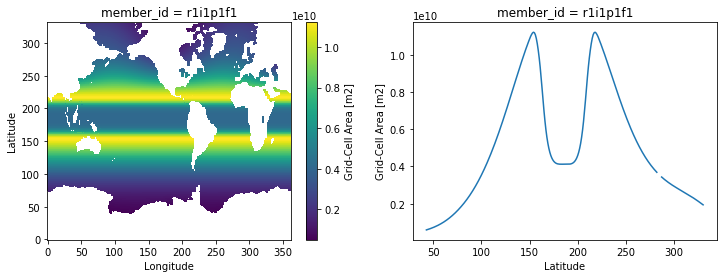

In [86]:
# Make a map of ocean area as well as a meridional plot

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ds_85_oa.areacello.plot()
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

ax2 = fig.add_subplot(1, 2, 2)
ds_85_oa.areacello.isel(x=110).plot()
ax2.set_xlabel('Latitude')

# Save Data Frames

#this will allow for easy access in sucessive notebooks

In [114]:
# Check File type
type(ds_hist) 

xarray.core.dataset.Dataset

In [115]:
# Check file size for intpp
print('file size (GB):', ds_hist.nbytes / 1e9) 

file size (GB): 0.957192928


In [117]:
# Check file size for oa
print('file size (GB):', ds_hist_oa.nbytes / 1e9) 

file size (GB): 0.005768864


In [112]:
# Save files to my Cheyenne folder for easy access
ds_hist.to_netcdf('hist_intpp.nc') 
ds_85.to_netcdf('ssp585_intpp.nc') 
ds_hist_oa.to_netcdf('hist_oa.nc') 
ds_85_oa.to_netcdf('ssp585_oa.nc') 